In [522]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [523]:
df = pd.read_csv('data/final_combined_dataset.csv')

In [524]:
df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])

In [525]:
# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

In [526]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52234 entries, 0 to 52233
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  52234 non-null  datetime64[ns]
 1   week                                  52234 non-null  int64         
 2   cases                                 52234 non-null  int64         
 3   population                            52234 non-null  int64         
 4   tempe_min                             52234 non-null  float64       
 5   humidity_max                          52234 non-null  float64       
 6   humidity_avg                          52234 non-null  float64       
 7   humidity_min                          52234 non-null  float64       
 8   temp_avg                              52234 non-null  float64       
 9   temp_max                              52234 non-null  float64       
 10

In [527]:
geocode_list = [3303807]
df = df[df['geocode'].isin(geocode_list)]
df = df.drop(columns=['geocode'])

In [528]:
df['cases_lag1'] = df['cases'].shift(1)
df['cases_lag2'] = df['cases'].shift(2)
df['cases_lag3'] = df['cases'].shift(3)
df['cases_lag4'] = df['cases'].shift(4)

# lag nearby_cases_weighted 4 weeks
df['nearby_cases_weighted_lag1'] = df['nearby_cases_weighted'].shift(1)
df['nearby_cases_weighted_lag2'] = df['nearby_cases_weighted'].shift(2)
df['nearby_cases_weighted_lag3'] = df['nearby_cases_weighted'].shift(3)
df['nearby_cases_weighted_lag4'] = df['nearby_cases_weighted'].shift(4)

df

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,...,week_sin,week_cos,cases_lag1,cases_lag2,cases_lag3,cases_lag4,nearby_cases_weighted_lag1,nearby_cases_weighted_lag2,nearby_cases_weighted_lag3,nearby_cases_weighted_lag4
29274,2012-01-01,201201,1,43680,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,...,1.000000,7.185429e-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29275,2012-01-08,201202,0,43680,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,...,0.992709,-1.205367e-01,1.0,NaN,NaN,NaN,0.794193,NaN,NaN,NaN
29276,2012-01-15,201203,2,43680,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,...,0.970942,-2.393157e-01,0.0,1.0,NaN,NaN,0.491000,0.794193,NaN,NaN
29277,2012-01-22,201204,3,43680,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,...,0.935016,-3.546049e-01,2.0,0.0,1.0,NaN,0.000000,0.491000,0.794193,NaN
29278,2012-01-29,201205,2,43680,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,...,0.885456,-4.647232e-01,3.0,2.0,0.0,1.0,0.348442,0.000000,0.491000,0.794193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29843,2022-11-27,202248,0,43680,18.857143,99.151789,79.717112,62.238677,23.775511,27.857143,...,0.663123,-7.485107e-01,7.0,11.0,10.0,15.0,2.562122,0.103270,4.975149,3.075556
29844,2022-12-04,202249,3,43680,20.285714,100.000000,77.826146,58.211681,25.071428,28.857143,...,0.568065,-8.229839e-01,0.0,7.0,11.0,10.0,0.057725,2.562122,0.103270,4.975149
29845,2022-12-11,202250,3,43680,18.833333,98.002307,77.462712,61.559047,23.904762,27.833333,...,0.464723,-8.854560e-01,3.0,0.0,7.0,11.0,0.402506,0.057725,2.562122,0.103270
29846,2022-12-18,202251,8,43680,19.500000,96.987255,82.448150,74.983709,22.517858,24.500000,...,0.354605,-9.350162e-01,3.0,3.0,0.0,7.0,0.000000,0.402506,0.057725,2.562122


In [529]:
df.isnull().sum()

date                                    0
week                                    0
cases                                   0
population                              0
tempe_min                               0
humidity_max                            0
humidity_avg                            0
humidity_min                            0
temp_avg                                0
temp_max                                0
city                                    0
vim                                     0
vim_monthly                             0
precipitation_avg_ordinary_kriging      0
precipitation_max_ordinary_kriging      0
precipitation_avg_regression_kriging    0
precipitation_max_regression_kriging    0
long                                    0
lat                                     0
cases_per_100k                          0
nearby_cases_weighted                   0
date_ordinal                            0
year                                    0
month                             

In [530]:
df.shape

(574, 36)

In [531]:
df = df.dropna()

In [532]:
train_df = df[df['date'].dt.year <= 2020]
test_df = df[df['date'].dt.year >= 2021]

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (466, 36)
Test set shape: (104, 36)


In [533]:
X_train = train_df.drop(columns=['cases_per_100k', 'cases'])
y_train = train_df[['cases', 'city']]

X_test = test_df.drop(columns=['cases_per_100k', 'cases'])
y_test = test_df[['cases', 'city']]

test_df = test_df.iloc[4:].reset_index(drop=True)

In [534]:
columns_to_not_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'cases', 'cases_per_100k']
numeric_cols = [
    col for col in df.select_dtypes(include=['float64', 'int64', 'int32']).columns
    if col not in columns_to_not_scale
]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale the selected numeric features
X_train[numeric_cols] = feature_scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = feature_scaler.transform(X_test[numeric_cols])

# Separate the city column from y_train and y_test (assuming 'city' is a column in y_train and y_test)
city_train = y_train['city']
city_test = y_test['city']

# Separate the target (cases) column from y_train and y_test
y_train_cases = y_train.drop('city', axis=1)  # Remove the 'city' column from y_train
y_test_cases = y_test.drop('city', axis=1)  # Remove the 'city' column from y_test

# Scale the target (cases) values
y_train = target_scaler.fit_transform(y_train_cases)
y_test = target_scaler.transform(y_test_cases)

# Recombine the city column with the scaled target values
y_train = pd.DataFrame(y_train, columns=['cases'])
y_train['city'] = city_train.reset_index(drop=True)

y_test = pd.DataFrame(y_test, columns=['cases'])
y_test['city'] = city_test.reset_index(drop=True)

In [535]:
# Feature columns you want to select
feature_cols = [
    'temp_avg', 'humidity_avg', 'cases_lag1', 'cases_lag2', 'nearby_cases_weighted_lag1', 'precipitation_max_regression_kriging', 'week_sin', 'month_sin', 'week_cos', 'month_cos']

In [536]:
# Function to create overlapping sequences
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length].values)  # Select seq_length rows as input
        y.append(target.iloc[i + seq_length])  # Select the next row as the target
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 4

# Group data by city
city_groups_xtrain = X_train.groupby('city')
city_groups_xtest = X_test.groupby('city')

city_groups_ytrain = y_train.groupby('city')
city_groups_ytest = y_test.groupby('city')

# Initialize dictionaries to store the processed data for each city
X_train_citywise_seq = {}
y_train_citywise_seq = {}
X_test_citywise_seq = {}
y_test_citywise_seq = {}

# Process training data city-wise
for city, X_train_city in city_groups_xtrain:
    y_train_city = city_groups_ytrain.get_group(city)  # Get the corresponding target group
    # Reset index to ensure continuous indexing
    y_train_city = y_train_city.reset_index(drop=True)
    X_seq, y_seq = create_sequences(X_train_city[feature_cols], y_train_city['cases'], seq_length)  # Use 'cases' as target
    X_train_citywise_seq[city] = X_seq
    y_train_citywise_seq[city] = y_seq
    print(f"Processed X_train and y_train for city: {city}, X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")

# Process testing data city-wise
for city, X_test_city in city_groups_xtest:
    y_test_city = city_groups_ytest.get_group(city)  # Get the corresponding target group
    # Reset index to ensure continuous indexing
    y_test_city = y_test_city.reset_index(drop=True)
    X_seq, y_seq = create_sequences(X_test_city[feature_cols], y_test_city['cases'], seq_length)  # Use 'cases' as target
    X_test_citywise_seq[city] = X_seq
    y_test_citywise_seq[city] = y_seq
    print(f"Processed X_test and y_test for city: {city}, X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")


Processed X_train and y_train for city: paraty, X_seq shape: (462, 4, 10), y_seq shape: (462,)
Processed X_test and y_test for city: paraty, X_seq shape: (100, 4, 10), y_seq shape: (100,)


In [537]:
# Define sequence length for LSTM
seq_length = 4

# Function to build and compile the model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)  # Predicting a single value (cases)
    ])
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mae'])
    return model

# Loop through each city dataset
city_models = {}
city_histories = {}
city_predictions = {}

for city in X_train_citywise_seq.keys():
    print(f"Processing city: {city}")

    # Get city-specific data
    X_train_city = X_train_citywise_seq[city]
    y_train_city = y_train_citywise_seq[city]
    X_test_city = X_test_citywise_seq[city]
    y_test_city = y_test_citywise_seq[city]

    # Ensure input shape matches the LSTM model
    input_shape = (seq_length, X_train_city.shape[2])

    # Build the model
    model = build_lstm_model(input_shape)

    # Train the model
    history = model.fit(
        X_train_city, y_train_city,
        epochs=50,
        batch_size=32,
        validation_data=(X_test_city, y_test_city),
        verbose=1
    )

    # Evaluate the model
    test_loss, test_mae = model.evaluate(X_test_city, y_test_city)
    print(f"City: {city}, Test Loss: {test_loss}, Test MAE: {test_mae}")

    # Save the model for this city
    model.save(f"lstm_dengue_prediction_model_{city}.h5")

    # Predict on test data
    predictions = model.predict(X_test_city)

    # Store results
    city_models[city] = model
    city_histories[city] = history
    city_predictions[city] = predictions

    print(f"Completed processing for city: {city}\n")

Processing city: paraty
Epoch 1/50


C:\Users\ASUS\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0174 - mae: 0.0762 - val_loss: 0.0113 - val_mae: 0.0845
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0155 - mae: 0.0801 - val_loss: 0.0094 - val_mae: 0.0697
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0149 - mae: 0.0724 - val_loss: 0.0085 - val_mae: 0.0666
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0120 - mae: 0.0655 - val_loss: 0.0089 - val_mae: 0.0568
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0099 - mae: 0.0568 - val_loss: 0.0069 - val_mae: 0.0616
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 - mae: 0.0523 - val_loss: 0.0070 - val_mae: 0.0580
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mae: 0.0494 - val_loss: 0.0071 - val_mae: 0.0599
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0517 - val_loss: 0.0089 - val_mae: 0.0575
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - mae: 0.04

City: paraty, Test Loss: 0.008419476449489594, Test MAE: 0.05355612933635712
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Completed processing for city: paraty



City: paraty - Actual Values Shape: (100,)
City: paraty - Predicted Values Shape: (100,)


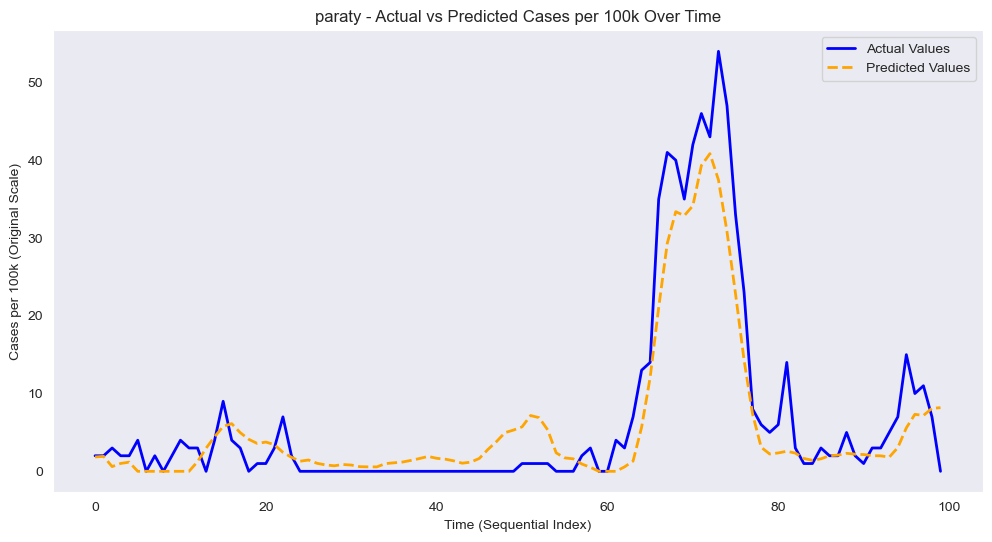

City: paraty - RMSE: 4.557026143966967


In [538]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Function to plot Actual vs Predicted and calculate RMSE
def plot_actual_vs_predicted(city, y_test_city, predictions_city, target_scaler):
    # Ensure to only pass the target variable (numeric values) to the scaler
    y_test_values = y_test_city['cases'].values  # Assuming 'cases' is the target column
    predictions_original_scale = target_scaler.inverse_transform(predictions_city)
    actual_values_original_scale = target_scaler.inverse_transform(y_test_values.reshape(-1, 1))  # Reshape for scaling

    # Ensure both predictions and actual values have the same length
    min_length = min(len(actual_values_original_scale), len(predictions_original_scale))

    actual_values_original_scale = actual_values_original_scale[:min_length].flatten()
    predictions_original_scale = predictions_original_scale[:min_length].flatten()
    predictions_original_scale[predictions_original_scale < 0] = 0

    time_index = np.arange(min_length)

    # Print shapes
    print(f"City: {city} - Actual Values Shape:", actual_values_original_scale.shape)
    print(f"City: {city} - Predicted Values Shape:", predictions_original_scale.shape)

    # Plot Actual vs Predicted
    plt.figure(figsize=(12, 6))
    plt.plot(time_index, actual_values_original_scale, label="Actual Values", color='blue', linewidth=2)
    plt.plot(time_index, predictions_original_scale, label="Predicted Values", color='orange', linewidth=2, linestyle='--')
    plt.xlabel("Time (Sequential Index)")
    plt.ylabel("Cases per 100k (Original Scale)")
    plt.title(f"{city} - Actual vs Predicted Cases per 100k Over Time")
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_values_original_scale, predictions_original_scale))
    print(f"City: {city} - RMSE: {rmse}")

# Loop through each city's predictions and plot
for city in city_predictions.keys():
    predictions_city = city_predictions[city]
    y_test_city = city_groups_ytest.get_group(city)

    # Call the function to plot and calculate RMSE
    plot_actual_vs_predicted(city, y_test_city, predictions_city, target_scaler)